## Kalashnik et Kalashnik 2011 - Tests

In [1]:
# General
# import glob
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# # from matplotlib.colors import Normalize
# # from matplotlib.colors import ListedColormap
# # import matplotlib.cm as cm
import pandas as pd

# PyTorch
import torch
import torch.nn as nn
from torch.autograd import Variable              # Convert arrays to tensors
from torch.utils.data import Dataset, DataLoader # Create a Dataset class to combine with DataLoader (= mini batches selection)
import pytorch_lightning as pl

# Data treatment
# import dask as da
# from dask.diagnostics import ProgressBar
# import zarr
# from scipy.interpolate import griddata
from datetime import datetime
from sklearn.linear_model import LinearRegression

# Custom
import functions as f
import dataUtils as du

# Statistics
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
def vm(t, lbda=1.5):
    num = np.exp(-t) - np.exp((1 - lbda) * t)
    den = lbda - 2
    return num /den

def rm(t):
    return np.exp(-t)

In [11]:
# lbda = 1.5 # lambda parameter
# ts   = np.linspace(0, 10, 1000)

# for lbda in [0.9, 1.1, 1.5, 1.9, 2.1]:
#     plt.title('Lambda = {}'.format(lbda), weight='bold')
#     plt.plot(vm(ts, lbda), c='tab:red', label='Vmax')
#     plt.plot(rm(ts),       c='k',       label='Rmax')
#     plt.legend()
#     plt.grid()
#     plt.xlabel('time unit');plt.ylabel('Vm and Rm units of initial values')
#     plt.show()

/tmp/ipykernel_24988/3041417967.py:4: RuntimeWarning: invalid value encountered in true_divide
  return num /den


Text(0, 0.5, 'Vm and Rm units of initial values')

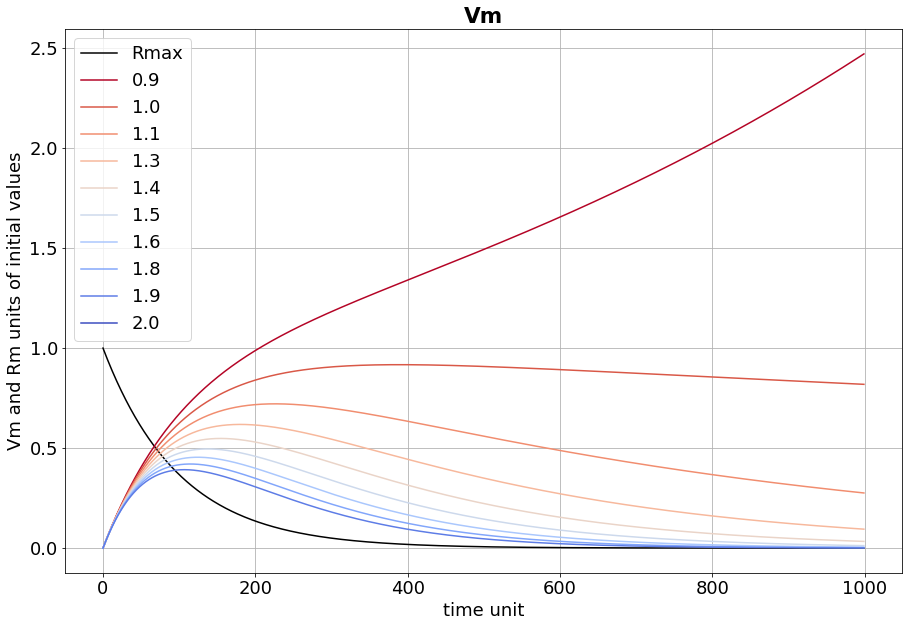

In [22]:
ts     = np.linspace(0, 10, 1000)
lbdas  = np.linspace(0.9, 2, 10)
colors = mpl.cm.coolwarm_r(np.linspace(0, 1, len(lbdas)))

plt.title('Vm', weight='bold')
plt.plot(rm(ts),       c='k',       label='Rmax')

for i, lbda in enumerate(lbdas):
    plt.plot(vm(ts, lbda), label='{:.1f}'.format(lbda), c=colors[i])
plt.legend()
plt.grid()
plt.xlabel('time unit');plt.ylabel('Vm and Rm units of initial values')

/tmp/ipykernel_24988/3041417967.py:4: RuntimeWarning: invalid value encountered in true_divide
  return num /den


Text(0, 0.5, 'Mm and Rm units of initial values')

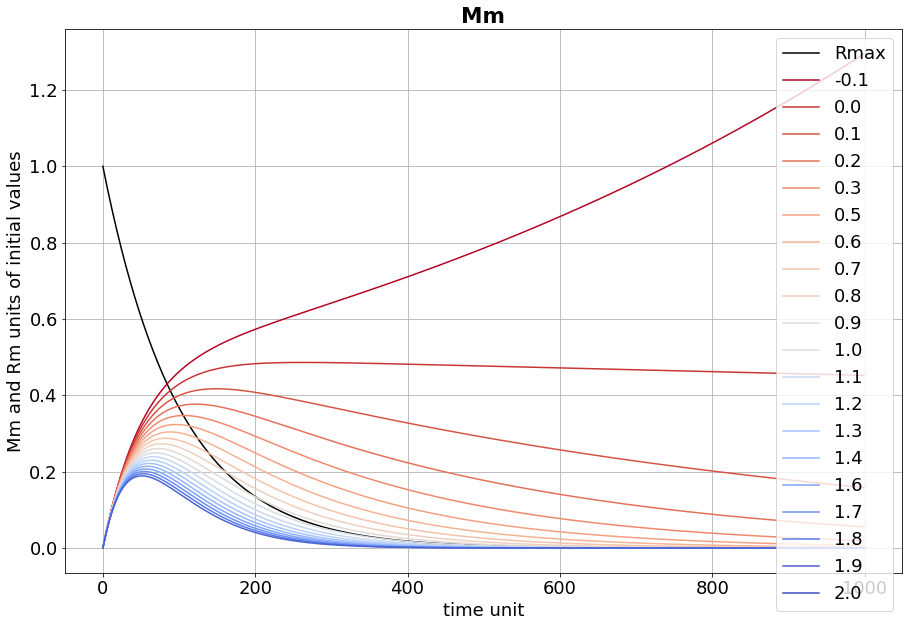

In [21]:
ts     = np.linspace(0, 10, 1000)
lbdas  = np.linspace(-0.1, 2, 20)
colors = mpl.cm.coolwarm_r(np.linspace(0, 1, len(lbdas)))

plt.title('Mm', weight='bold')
plt.plot(rm(ts),       c='k',       label='Rmax')

for i, lbda in enumerate(lbdas):
    plt.plot(rm(ts) * vm(ts, lbda), label='{:.1f}'.format(lbda), c=colors[i])
plt.legend()
plt.grid()
plt.xlabel('time unit');plt.ylabel('Mm and Rm units of initial values')

In [5]:
def vm2(t, lbda=1.5, tau=1.):
    num = np.exp(-t / tau) - np.exp((1 / tau - lbda) * t)
    den = lbda - (2 / tau)
    return num / den

def rm2(t, tau=1.):
    return np.exp(-t / tau)

/tmp/ipykernel_24988/1653025495.py:4: RuntimeWarning: invalid value encountered in true_divide
  return num / den


Text(0, 0.5, 'Vm and Rm units of initial values')

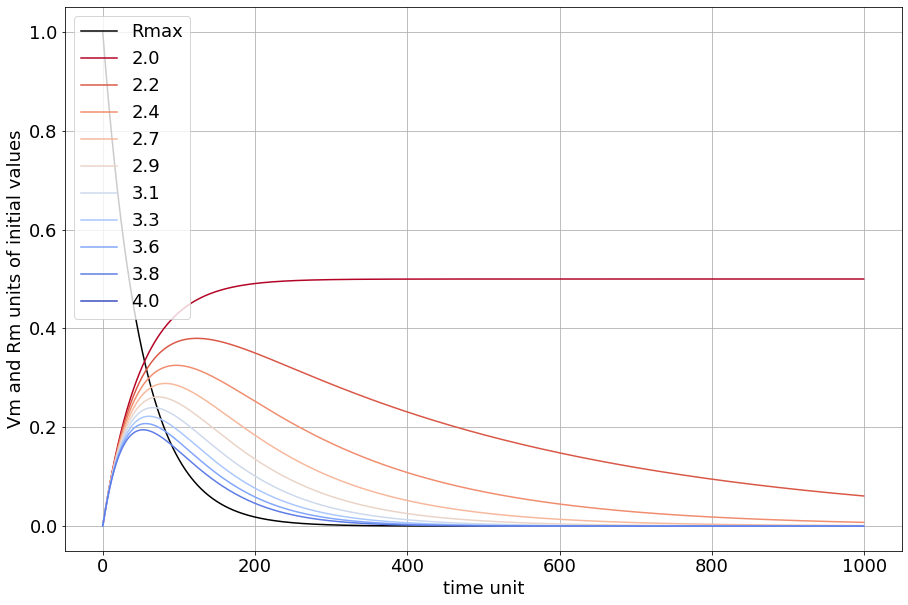

In [6]:
tau    = 0.5
ts     = np.linspace(0, 10, 1000)
lbdas  = np.linspace(1, 2, 10) * (1 / tau)
colors = mpl.cm.coolwarm_r(np.linspace(0, 1, len(lbdas)))

plt.plot(rm2(ts, tau=tau),       c='k',       label='Rmax')
for i, lbda in enumerate(lbdas):
    plt.plot(vm2(ts, lbda, tau=tau), label='{:.1f}'.format(lbda), c=colors[i])
plt.legend()
plt.grid()
plt.xlabel('time unit');plt.ylabel('Vm and Rm units of initial values')

In [7]:
def vm3(t, lbda=1.5, tau=1.):
    num = np.exp(tau - t) - np.exp((1 / lbda) * (t - tau))
    den = lbda - 2
    return num / den

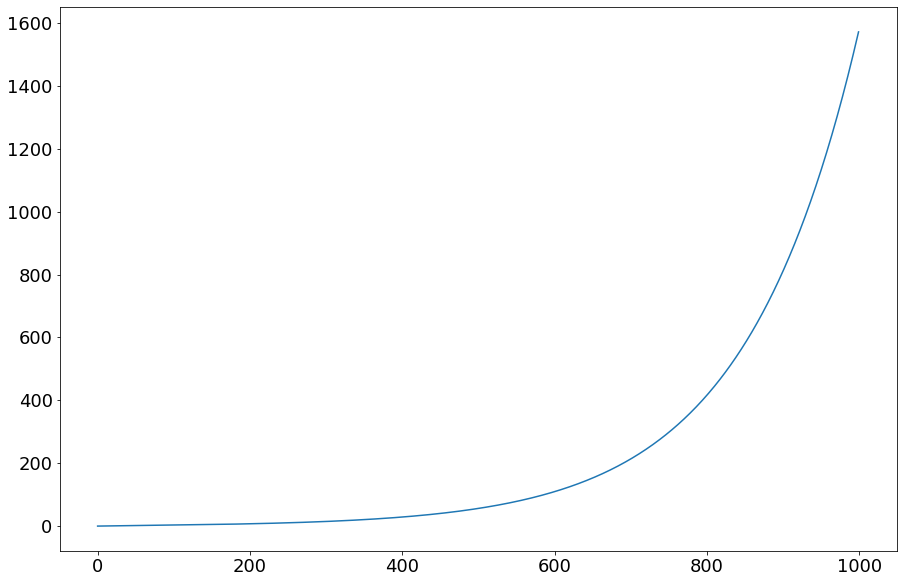

In [8]:
plt.plot(vm3(ts, lbda=1.5, tau=0))

/tmp/ipykernel_24988/1084057792.py:4: RuntimeWarning: divide by zero encountered in true_divide
  return num / den
/tmp/ipykernel_24988/1084057792.py:4: RuntimeWarning: invalid value encountered in true_divide
  return num / den


Text(0, 0.5, 'Vm and Rm units of initial values')

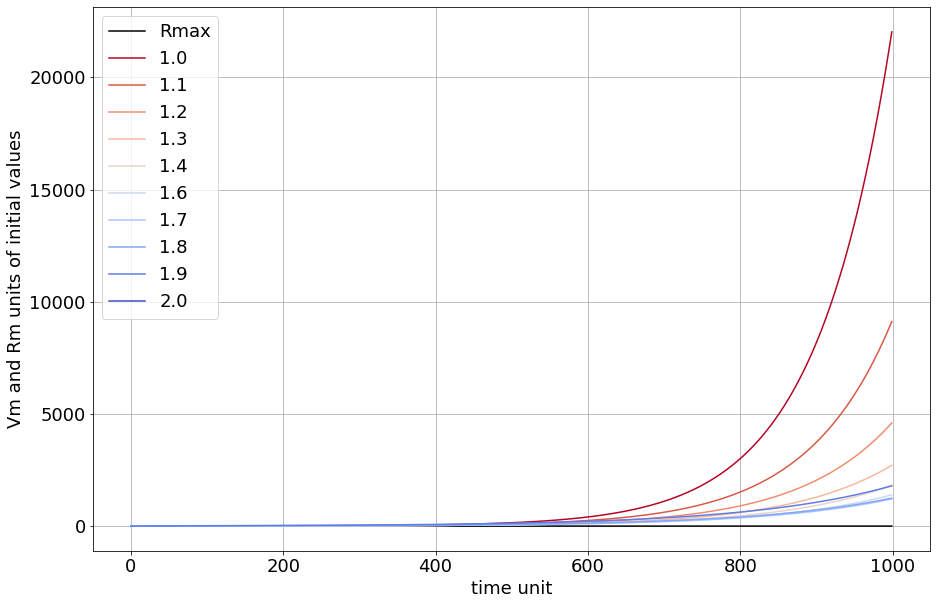

In [9]:
tau    = 0
ts     = np.linspace(0, 10, 1000)
lbdas  = np.linspace(1, 2, 10)
colors = mpl.cm.coolwarm_r(np.linspace(0, 1, len(lbdas)))

plt.plot(rm(ts),       c='k',       label='Rmax')
for i, lbda in enumerate(lbdas):
    plt.plot(vm3(ts, lbda, tau=tau), label='{:.1f}'.format(lbda), c=colors[i])
plt.legend()
plt.grid()
plt.xlabel('time unit');plt.ylabel('Vm and Rm units of initial values')

#### Non zero Rmax at t >> 1

Text(0, 0.5, 'Vm and Rm (adimensional)')

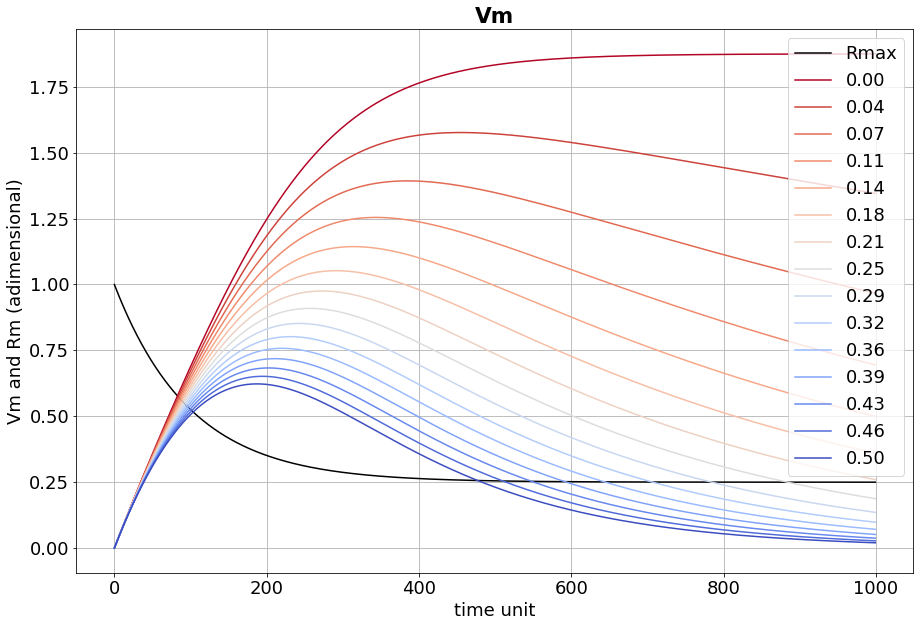

In [47]:
def vm(t, lbda=1.5, r_star=0.25):
    den = np.exp(-t) * (1 - r_star) + r_star
    a   = ((1 - r_star) ** 2) * (np.exp(-2 * t) - np.exp(-lbda * t)) / (lbda - 2)
    b   = r_star * (1 - r_star) * (np.exp(-t) - np.exp(-lbda * t)) / (lbda - 1)
    return (a + b) / den

def rm(t, r_star=0.25):
    return np.exp(-t) + (1 - np.exp(-t)) * r_star

ts     = np.linspace(0, 10, 1000)
lbdas  = np.linspace(0, 0.5, 15)
colors = mpl.cm.coolwarm_r(np.linspace(0, 1, len(lbdas)))

plt.title('Vm', weight='bold')
plt.plot(rm(ts),       c='k',       label='Rmax')

for i, lbda in enumerate(lbdas):
    plt.plot(vm(ts, lbda), label='{:.2f}'.format(lbda), c=colors[i])
plt.legend()
plt.grid()
plt.xlabel('time unit');plt.ylabel('Vm and Rm (adimensional)')